In [ ]:
%cd ..

In [2]:
import torch
from model.resnet import Prototype
from data import get_labeled_set, get_unlabeled_set, make_bounding_box_images, tensor_to_image

import matplotlib.pyplot as plt
import numpy as np

In [3]:
model = Prototype()
model.device = 'cpu'
model.is_variational = True

file_path = './resvar_weights/labeled-resnet-latest.torch'
model.load_state_dict(torch.load(file_path, 
                                 map_location=torch.device('cpu')))
model = model.eval()

In [4]:
_, unlabeled_trainloader = get_unlabeled_set(batch_size=3)
images, _ = iter(unlabeled_trainloader).next()

In [5]:
img = images[0]
img_recon = model(img[None, ...])

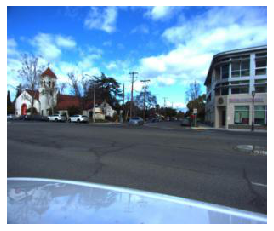

In [6]:
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.axis('off');

In [7]:
img_recon = torch.sigmoid(img_recon[0])

In [8]:
img_recon.shape

torch.Size([1, 3, 256, 306])

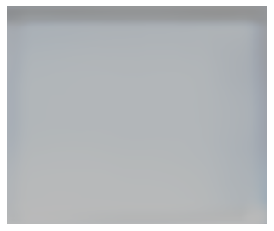

In [9]:
plt.imshow(img_recon[0].detach().numpy().transpose(1, 2, 0))
plt.axis('off');

In [10]:
(_, labeled_trainloader), (_, labeled_testloader) = get_labeled_set(batch_size=3, validation=0.2)

Validation Index: 128


In [11]:
images, targets, _ = iter(labeled_testloader).next()

In [12]:
imgs = images[0]

In [13]:
imgs[None, ...].shape

torch.Size([1, 6, 3, 256, 306])

In [14]:
recon_map , _, _= model(imgs[None, ...], mode='object-map')

In [15]:
recon_map.shape

torch.Size([1, 10, 800, 800])

In [16]:
recon_map[0][0]

tensor([[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
        ...,
        [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311]],
       grad_fn=<SelectBackward>)

In [17]:
torch.sigmoid(recon_map[0][0])

tensor([[0.6750, 0.6750, 0.6750,  ..., 0.6750, 0.6750, 0.6750],
        [0.6750, 0.6750, 0.6750,  ..., 0.6750, 0.6750, 0.6750],
        [0.6750, 0.6750, 0.6750,  ..., 0.6750, 0.6750, 0.6750],
        ...,
        [0.6750, 0.6750, 0.6750,  ..., 0.6750, 0.6750, 0.6750],
        [0.6750, 0.6750, 0.6750,  ..., 0.6750, 0.6750, 0.6750],
        [0.6750, 0.6750, 0.6750,  ..., 0.6750, 0.6750, 0.6750]],
       grad_fn=<SigmoidBackward>)

In [18]:
channel = 3
mask = torch.softmax(recon_map[0], 0).detach().numpy()[channel] * 255.0
mask

array([[25.5, 25.5, 25.5, ..., 25.5, 25.5, 25.5],
       [25.5, 25.5, 25.5, ..., 25.5, 25.5, 25.5],
       [25.5, 25.5, 25.5, ..., 25.5, 25.5, 25.5],
       ...,
       [25.5, 25.5, 25.5, ..., 25.5, 25.5, 25.5],
       [25.5, 25.5, 25.5, ..., 25.5, 25.5, 25.5],
       [25.5, 25.5, 25.5, ..., 25.5, 25.5, 25.5]], dtype=float32)

In [19]:
bboxes = make_bounding_box_images(targets)

mask_target = bboxes[0][channel].numpy()

In [20]:
np.unique(recon_map.detach())

array([0.7310586], dtype=float32)

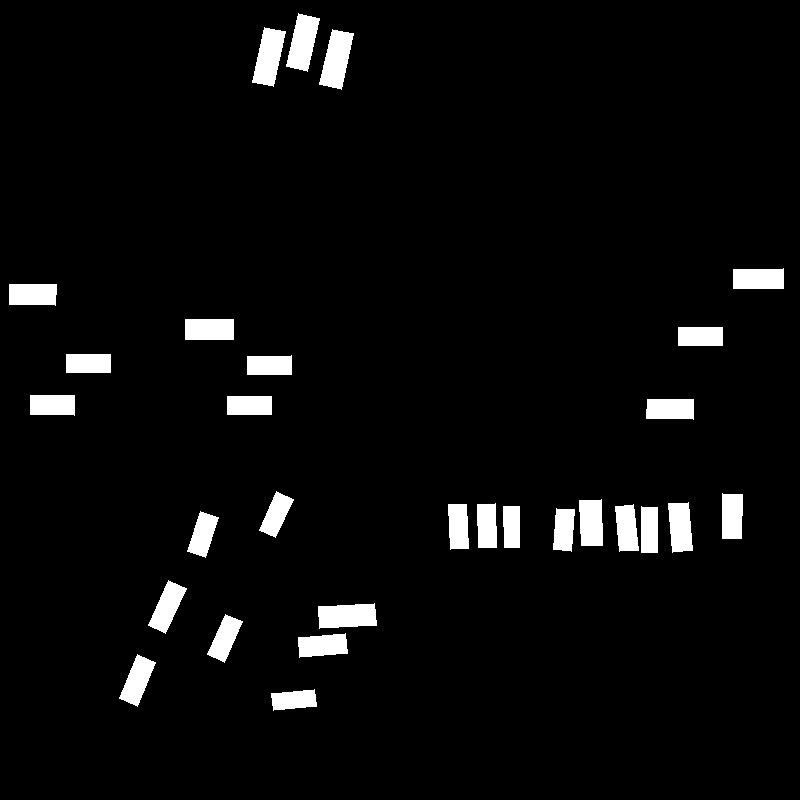

In [21]:
tensor_to_image(bboxes[0], 3)

In [22]:
# tensor_to_image(torch.softmax(recon_map[0], 0), astype='float', channel=3)
t = recon_map[0]
t

tensor([[[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         ...,
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311]],

        [[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         ...,
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311]],

        [[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.

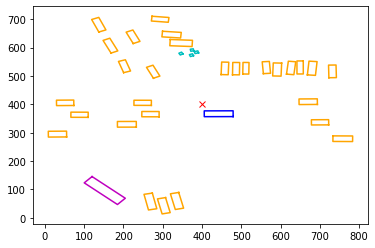

In [23]:
import matplotlib.pyplot as plt
from helpers.helper import draw_box
# The center of image is 400 * 400
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
# ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(targets[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works
    draw_box(ax, bb, color=color_list[targets[0]['category'][i]])